In [1]:
# used during development to releoad modules every time there is a change
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from risk_kit import Metrics, pre_processing_ind, get_ind30_nfirms, get_ind30_size, plot_ef2
import ipywidgets as widgets
from IPython.display import display

pd.options.display.float_format = '{:.6f}'.format

### GHP Construction with Duration Matching
If we can find a set of ZC bonds that match our liabilities this would the best solution compared to have assets invested in cash. The problem is that it is not easy to find a set of ZC bonds that matches perfectly our liabilities. Therefore we are going to work around this problem by holding a portfolio of regular coupon paying bonds as long as we can match the duration.

In [2]:
m=Metrics()

In [3]:
# 3 year bond, with coupons per year
m.bond_cash_flows(3, 100, 0.03, 2)

1     1.500000
2     1.500000
3     1.500000
4     1.500000
5     1.500000
6   101.500000
dtype: float64

In [4]:
# bond that pays 5% per year that is higher than current interest rate (or discount rate)
# it is selling at a premium
m.bond_price(20, 1000, 0.05, 2, 0.04) 

1136.7773962036904

In [5]:
m.bond_price(20, 1000, 0.05, 2, 0.05)

1000.0000000000025

In [6]:
# as interest rate falls bond price rise
m.bond_price(20, 1000, 0.05, 2, 0.02)

1492.520291709342

In [8]:
rates = np.linspace(.01, .1, num=20)
rates

array([0.01      , 0.01473684, 0.01947368, 0.02421053, 0.02894737,
       0.03368421, 0.03842105, 0.04315789, 0.04789474, 0.05263158,
       0.05736842, 0.06210526, 0.06684211, 0.07157895, 0.07631579,
       0.08105263, 0.08578947, 0.09052632, 0.09526316, 0.1       ])

In [10]:
prices = [m.bond_price(10, 1000, .05, 2, rate) for rate in rates]

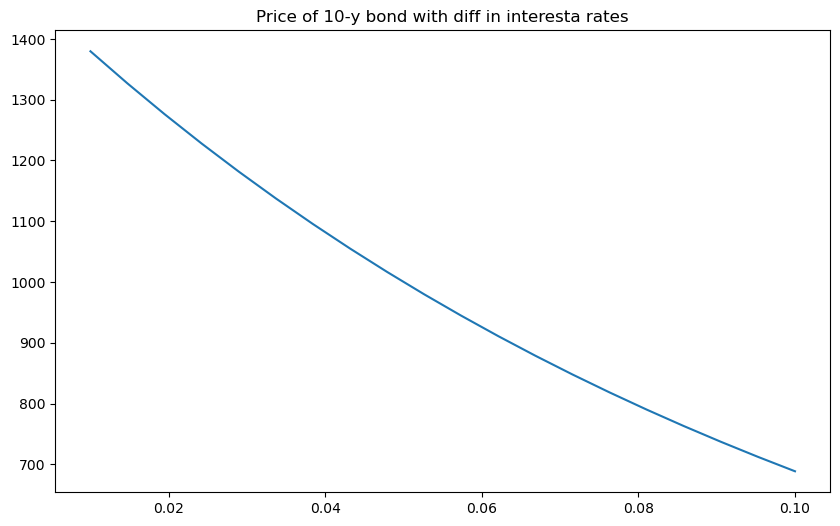

In [11]:
pd.DataFrame(data=prices, index=rates).plot(title="Price of 10-y bond with diff in interesta rates",\
                                            legend=False);

COMMENT: using a coupon-paying bond as hedge is not a good idea. We need to a combination of coupon-paying bonds that is immune to change in interest rates

In [12]:
cf = m.bond_cash_flows(3, 1000, 0.06, 2)
cf

1     30.000000
2     30.000000
3     30.000000
4     30.000000
5     30.000000
6   1030.000000
dtype: float64

In [13]:
cf.index

Int64Index([1, 2, 3, 4, 5, 6], dtype='int64')

In [14]:
# let's compute the discount factor
discounts = m.discount(cf.index, 0.06/2)
discounts

Float64Index([ 0.970873786407767, 0.9425959091337544, 0.9151416593531596,
              0.8884870479156888, 0.8626087843841639, 0.8374842566836542],
             dtype='float64')

In [15]:
# present values of the future cash flows
dcf = discounts*cf
dcf

1    29.126214
2    28.277877
3    27.454250
4    26.654611
5    25.878264
6   862.608784
dtype: float64

In [17]:
# coverting them into a set of weights
weights = dcf/dcf.sum()
weights

1   0.029126
2   0.028278
3   0.027454
4   0.026655
5   0.025878
6   0.862609
dtype: float64

In [19]:
# weighted average of all the periods: This is the weighted average time,
#I am waiting to get all my money back
macaulay_duration = (cf.index * weights).sum()
macaulay_duration

5.579707187194534

COMMENT: This duration is direcly linked to the amount of the change in price when interest rate change. If interest rate move and you have a large duration (macaulay duration is almost the first derivative of the change in price wrt interest rates). The prices move a lot. If duration is short the prices don't move much . For a ZC Bond since there is only one payment the macaulay duration is exactly the maturity. For coupon-paying bond the macaulay duration is always less then the maturity. If we match the macaulay duration of your bonds to the macaulay duration of our liabilities we get two porfolios that have the same sensitivity to the interest rate. This is a not perfect match it is only valid for yield curves that have parallel shifts. We know that there are more complex behaviour of the yield curve (it can steepen, it can flatten, it can show added curvature....). However the level of the yield curve is the major one and we are in a very good place to start as first order approximation.

In [20]:
macaulay_duration = m.macaulay_duration(m.bond_cash_flows(3, 1000, 0.06, 2), 0.06/2)
macaulay_duration

5.579707187194534

## Duration Matching

In [21]:
# Let's immagine we have got two liabilities
liabilities = pd.Series(data=[100000, 100000], index=[10, 12])

In [23]:
# at the end of the days, liabilities are just cash flows
m.macaulay_duration(liabilities, 0.04)

10.960799385088393

If we had a ZC Bond of 10.96 duration it would be great or two ZC Bonds of 10 and 12 durations it would be great. Let's suppose we don't have them and we only have two types of bonds: 10-year and 20-year bonds. Each of them pays 5% coupon once per year and have a face value of 1000.

In [24]:
md_10 = m.macaulay_duration(m.bond_cash_flows(10, 1000, .05, 1), 0.04)
md_20 = m.macaulay_duration(m.bond_cash_flows(20, 1000, .05, 1), 0.04)

In [25]:
md_10, md_20

(8.190898824083233, 13.544718122145921)

we need to figure out what fraction we need to hold for each of them to get the same 10.96 duration of our combined liabilities. In our case the fraction in the short duration asset $w_s$ should be such that:
$$ w_s\times d_s + (1-w_s) \times d_l =d_t $$
rearranging the terms gives:
$$ w_s = \frac{d_l-d_t}{d_l-d_s}$$

In [26]:
short_bond = m.bond_cash_flows(10, 1000, .05, 1) # 10 years, face_value of 1000, coupon pays 5%, once per year
long_bond = m.bond_cash_flows(20, 1000, .05, 1) # 20 years, face_value of 1000, coupon pays 5%, once per year
w_s = m.match_duration(liabilities, short_bond, long_bond, 0.04) # discount_rate is 4%
w_s

0.48263092069478974

In [29]:
# let's build this portfolio of combined bonds
# price of short bond
p_short_bond = m.bond_price(10, 1000, 0.05, 1, 0.04)
# price of long bond
p_long_bond = m.bond_price(20, 1000, 0.05, 1, 0.04)
# starting asset
a_0= 130000
# concatenating the cashflows of two portfolios
# money put in the short bond is a_0*w_s divided by the price of the short bond
# gives the number of short bonds. Multiply the number of short bonds by the cash flow generated by
# them given by short_bond
# by using concat, index is not modified so as to preserve the coupon received at the right time
p_flows = pd.concat([(a_0*w_s/p_short_bond)*short_bond, (a_0*(1-w_s)/p_long_bond)*long_bond])
m.macaulay_duration(p_flows, 0.04)

10.960799385088393

COMMENT: as expected this is exact the same weighted duration of the liabilities

In [30]:
# Funding Ratio
cfr = m.funding_ratio(p_flows, liabilities, 0.04)
cfr

0.9998760012192478

COMMENT: I am pretty much funded

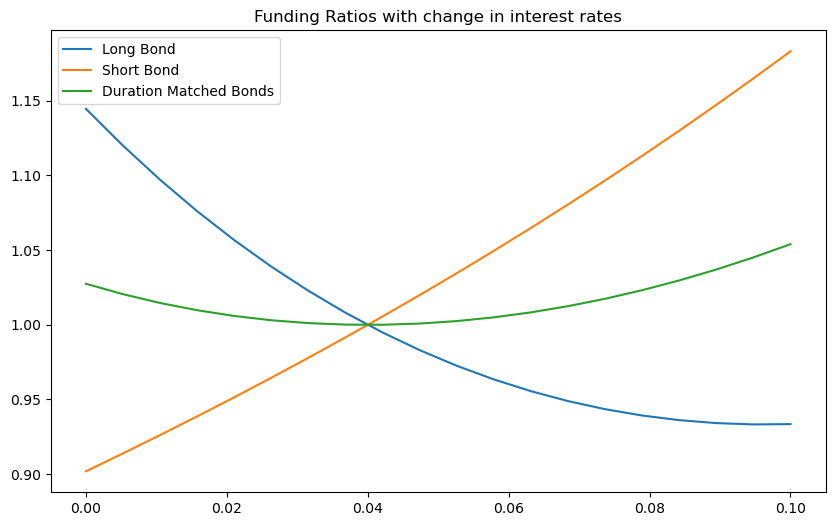

In [31]:
# let's look at a bunch of rates and compute a bunch of funding ratio as interest rate change 
# for a whole bunch of cash flows
rates = np.linspace(0, .1, 20)
# If I put 100% in my long bond asset I would get:
lb_assets = (a_0/p_long_bond)*long_bond
# If I put 100% in my short bond asset I would get:
sb_assets= (a_0/p_short_bond)*short_bond

fr_change = pd.DataFrame({
                        "Long Bond": [m.funding_ratio(lb_assets, liabilities, r) for r in rates],
                        "Short Bond": [m.funding_ratio(sb_assets, liabilities, r) for r in rates],
                        "Duration Matched Bonds": [m.funding_ratio(p_flows, liabilities, r) for r in rates]    
                        }, index = rates)

fr_change.plot(title="Funding Ratios with change in interest rates");

COMMENT: the duration matching portfolio is almost insensitive to change in interest rates.
Tu sum up, you construct a portfolio using regular coupon-paid bonds such that the duration of your liabilities
match the duration of your assets. No exposure to interest rates